In [2]:
import os
from os.path import basename
from multiprocessing.dummy import Pool as ThreadPool
import subprocess

import pandas as pd
import numpy as np
import pickle

import glob
from natsort import natsorted
import tqdm
from sklearn.preprocessing import StandardScaler
from keras.layers import Input, Dense, concatenate
from keras.models import Sequential, Model
from os import environ
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

# Libraries for data Processing
from pydub import AudioSegment # Requires ffmpeg. You can do "apt install ffmpeg" if you don't have it

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# README

In [ ]:
"""
In this demonstration, we use our trained model to predict emotion from songs that we can find online.
For model training, please refer to xxx.py
"""

# Data Processing

## Step 1: Converting mp3 to wav

In [8]:
""" 
You can use any music files you like. 
In this example, I use the first 1000 most popular songs from FMA
https://freemusicarchive.org/music/charts/all

I also filtered out the songs that is less than 60 seconds and longer than 10 minutes.
In the end, there are only 953 songs
"""

'You can use any music files you like. In this example, I use the first 1000 most popular songs from FMA'

In [3]:
inpath = './Z1-1000/' # Path to your mp3 files
output_path = './Z1-1000wav/' # Path to save your wav files results 
# (opensmile only supports wav files, so if your music files are not this format, you need to convert it to wav first)
# if your music files are already wav files, then you can skip this step
mp3s = os.listdir(inpath)

In [4]:
def mp3_2_wav(mp3,inpath=inpath,output_path=output_path):
    "This function is for converting mp3 files to wav files, since openSMILE only works for wav files"
    sound = AudioSegment.from_mp3(inpath+mp3)
    
    if os.path.exists(output_path)==False: # Check if the output folder exist
        os.makedirs(output_path) # If not, create the folder
    else:
        pass        
    sound.export(os.path.join(output_path,mp3[:-3]+'wav'), format="wav")

In [5]:
# Processing data with multi-threads
pool = ThreadPool(8)
pool.map(mp3_2_wav, mp3s)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

## Step 2: Extracting features using opensmile

In [6]:
# In this step, you need to install openSMILE to extract features from wav files.
# For me, I put the complied software in the same folder as ./SMILExtract
# The software can be downloaded here https://www.audeering.com/opensmile/

# After you have openSMILE installed, we also need a configuration file to tell the software what features to extract
# I have put the configuration file in the same folder as ./IS13_ComParE_lld-func.conf

In [7]:
inpath = './Z1-1000wav/'
outpath = './features/'

def extractFeatures(inpath, outpath):
    """Extracting features from wav files by calling SMILExtract"""
    
    def runcommand(command):
        subprocess.call(command, shell=True)    
    commands = []
    audios = os.listdir(inpath)
    pool = ThreadPool(40)
    
    if os.path.exists(outpath)==False: # Check if the output folder exist
        os.makedirs(outpath) # If not, create the folder
    else:
        pass        
    
    for audio in audios:
        command1 = "./SMILExtract -C IS13_ComParE_lld-func.conf -I " + str(inpath) + audio + " -O " + str(outpath) + audio[:-3] + "csv"
        commands.append(command1)
    pool.map(runcommand, commands)


extractFeatures(inpath,outpath)

## Step 3: Loading openSMILE features as numpy arrays

In [9]:
length_list = []
X_avg = [] # Create a list for storing the processed features
filenames = []
for file in tqdm.tqdm(natsorted(glob.glob('./features/*.csv'))):
    
    data = pd.read_csv(file,sep=';').drop('frameTime',axis=1)
    audio_len = data.shape[0]
    if audio_len < 600 and audio_len > 60: # filtering out songs that is more than 5 mins long and shorter than 30s
        X_avg.append(data.values.mean(0))
        filenames.append(os.path.basename(file[:-4]))
    else:
        pass

100%|██████████| 953/953 [00:39<00:00, 24.21it/s]


In [10]:
X_avg = np.array(X_avg) # Converting the list to numpy array.

## Step 4: Data Normalization

In [11]:
X_scaler = StandardScaler()

In [12]:
X_avg_norm = X_scaler.fit_transform(X_avg)

# TNN model

## Step 1: Defining the model

In [13]:
environ["CUDA_VISIBLE_DEVICES"]='0' # Selecting GPU

config= tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction=0.2 # Use 20% of the GPU memory
set_session(tf.Session(config=config))

In [14]:
def create_base_network(in_dims, out_dims):
    """
    Base network to be shared.
    """
    model = Sequential()
    model.add(Dense(out_dims, input_shape=(in_dims,),activation='relu'))
    # model.add(Dense(1024, input_shape=(in_dims,),activation='relu'))
    # model.add(Dense(512,activation='relu'))    
    # model.add(Dense(256,activation='relu'))       
    # model.add(Dense(out_dims,activation='relu')) 
    return model

input_dim = 260
anchor_input = Input((input_dim, ), name='anchor_input')
positive_input = Input((input_dim, ), name='positive_input')
negative_input = Input((input_dim, ), name='negative_input')

# Shared embedding layer for positive and negative items
Shared_DNN = create_base_network(input_dim, 100)


encoded_anchor = Shared_DNN(anchor_input)

TNN_model = Model(inputs=anchor_input, outputs=encoded_anchor)

Instructions for updating:
Colocations handled automatically by placer.


In [15]:
def compute_emotion(X_avg_norm, TNN_model, GMB_model, weight_path):
    TNN_model.load_weights(weight_path)
    transformed_X = TNN_model.predict(X_avg_norm)
    y_pred = GMB_model.predict(transformed_X)
    
    return y_pred

## Arousal prediction

In [16]:
GMB_model = pickle.load(open('./Weight/grad_model_arousal', 'rb'))
weight_path = r'./Weight/arousal_task1_triplet_Dense100_88nd_r2-0.6875515232584031.hdf5'

y_pred_arousal = compute_emotion(X_avg_norm, TNN_model, GMB_model, weight_path)

In [17]:
print(f'The arousal values for the songs are:\n {y_pred_arousal}')

The arousal values for the songs are:
 [0.60029277 0.75608682 0.48365754 0.52802984 0.75206128 0.3475996
 0.51095784 0.27620656 0.29008374 0.13615872 0.32529241 0.66620417
 0.64644912 0.46950495 0.60356943 0.65952872 0.1946222  0.80575451
 0.5298027  0.29695747 0.47394559 0.37818233 0.62971806 0.64373108
 0.70583541 0.66552795 0.47221956 0.53286219 0.24297111 0.33618326
 0.36949148 0.21926042 0.28591247 0.2973582  0.52341909 0.5405343
 0.30432724 0.26231588 0.81359715 0.30879977 0.13935107 0.57243357
 0.63311534 0.67250607 0.45848479 0.39766893 0.33935878 0.72301415
 0.67852965 0.38985347 0.74912316 0.20864409 0.57520065 0.47782632
 0.28876813 0.32495356 0.2213834  0.17504804 0.62580453 0.57077766
 0.60059221 0.55541219 0.106008   0.37087794 0.49943433 0.50780272
 0.39619975 0.37101101 0.30098521 0.70979963 0.63556836 0.32271404
 0.47139024 0.50650232 0.48301373 0.6474467  0.45045513 0.32571971
 0.61505276 0.50814057 0.72149024 0.22879308 0.58726062 0.49512384
 0.68773702 0.59123877 0.

## Valence prediction

In [18]:
GMB_model = pickle.load(open('./Weight/grad_model_valence', 'rb'))
weight_path = r'./Weight/task1_triplet_Dense260_89nd_r2-0.4087313673537267.hdf5'

y_pred_valence= compute_emotion(X_avg_norm, TNN_model, GMB_model, weight_path)

In [19]:
print(f'The valence values for the songs are:\n {y_pred_valence}')

The valence values for the songs are:
 [0.61284673 0.55987466 0.61039216 0.63504526 0.62195907 0.41294177
 0.50887903 0.37833308 0.39447406 0.35428787 0.47628572 0.6012664
 0.51563354 0.41060388 0.66865629 0.59711693 0.34419925 0.80636219
 0.51879195 0.48136129 0.46053479 0.43156815 0.56270055 0.60619746
 0.52463666 0.58827846 0.59823674 0.47956109 0.39212563 0.38358031
 0.47350869 0.40988583 0.25500796 0.37659802 0.52600823 0.53353706
 0.50426789 0.30919018 0.72445928 0.44130365 0.41083807 0.61404291
 0.62543171 0.59928944 0.58396309 0.41472011 0.48756765 0.60779669
 0.68166955 0.4813725  0.70605016 0.3468544  0.63888881 0.52800861
 0.34246267 0.30003524 0.3789602  0.3186506  0.50371071 0.34391229
 0.72562252 0.53288033 0.33927886 0.51468118 0.57683575 0.58422168
 0.43605867 0.47802803 0.36216748 0.74665967 0.6208892  0.44474943
 0.45214415 0.54780542 0.36698577 0.52049896 0.71769348 0.35246355
 0.57774187 0.43315485 0.66729912 0.38208052 0.59229741 0.70264124
 0.65446355 0.60058338 0

Text(0, 0.5, 'Arousal')

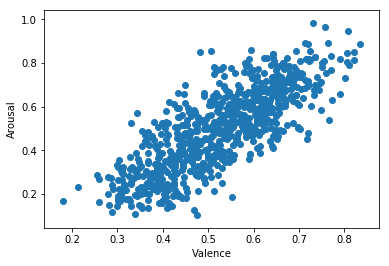

In [20]:
plt.scatter(y_pred_valence,y_pred_arousal)
plt.xlabel('Valence')
plt.ylabel('Arousal')

In [22]:
filenames

['Chart_1',
 'Chart_2',
 'Chart_3',
 'Chart_4',
 'Chart_5',
 'Chart_6',
 'Chart_7',
 'Chart_8',
 'Chart_9',
 'Chart_10',
 'Chart_11',
 'Chart_12',
 'Chart_13',
 'Chart_14',
 'Chart_15',
 'Chart_16',
 'Chart_17',
 'Chart_19',
 'Chart_20',
 'Chart_21',
 'Chart_22',
 'Chart_23',
 'Chart_24',
 'Chart_25',
 'Chart_26',
 'Chart_28',
 'Chart_29',
 'Chart_30',
 'Chart_31',
 'Chart_32',
 'Chart_33',
 'Chart_34',
 'Chart_35',
 'Chart_36',
 'Chart_37',
 'Chart_38',
 'Chart_39',
 'Chart_40',
 'Chart_41',
 'Chart_43',
 'Chart_44',
 'Chart_45',
 'Chart_46',
 'Chart_47',
 'Chart_48',
 'Chart_51',
 'Chart_54',
 'Chart_55',
 'Chart_57',
 'Chart_58',
 'Chart_59',
 'Chart_60',
 'Chart_61',
 'Chart_62',
 'Chart_64',
 'Chart_65',
 'Chart_66',
 'Chart_67',
 'Chart_68',
 'Chart_71',
 'Chart_72',
 'Chart_73',
 'Chart_74',
 'Chart_76',
 'Chart_77',
 'Chart_78',
 'Chart_79',
 'Chart_80',
 'Chart_81',
 'Chart_83',
 'Chart_85',
 'Chart_86',
 'Chart_87',
 'Chart_90',
 'Chart_91',
 'Chart_92',
 'Chart_93',
 'Chart_

In [23]:
df = pd.DataFrame(zip(filenames, y_pred_arousal, y_pred_valence), columns=['songID', 'arousal','valence'])

In [24]:
df.to_csv('FMA_av_prediction')